<a href="https://colab.research.google.com/github/Hasim-dev/Brain-Tumor-Diagnosis/blob/master/Brain_Tumor_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from PIL import Image

In [2]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasimdev/brain-mri-dataset # api copied from kaggle
import os
os.listdir('/content/')
import zipfile
with zipfile.ZipFile('/content/brain-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brain_tumor_dataset')

Saving kaggle.json to kaggle.json
 66% 5.00M/7.54M [00:00<00:00, 26.1MB/s]
100% 7.54M/7.54M [00:00<00:00, 36.6MB/s]


In [3]:
!ls

brain-mri-dataset.zip  brain_tumor_dataset  kaggle.json  sample_data


In [4]:
!ls brain_tumor_dataset

no  yes


In [5]:
!ls brain_tumor_dataset/yes

Y100.JPG  Y12.jpg   Y166.JPG  Y195.JPG	Y254.jpg  Y38.jpg  Y59.JPG  Y82.jpg
Y101.jpg  Y13.jpg   Y167.JPG  Y19.JPG	Y255.JPG  Y39.jpg  Y60.jpg  Y85.JPG
Y102.jpg  Y146.JPG  Y168.jpg  Y1.jpg	Y256.JPG  Y3.jpg   Y61.jpg  Y86.JPG
Y103.jpg  Y147.JPG  Y169.jpg  Y20.jpg	Y257.jpg  Y40.JPG  Y62.jpg  Y89.JPG
Y104.jpg  Y148.JPG  Y16.JPG   Y21.jpg	Y258.JPG  Y41.jpg  Y65.JPG  Y8.jpg
Y105.jpg  Y14.jpg   Y170.JPG  Y22.jpg	Y259.JPG  Y42.jpg  Y66.JPG  Y90.jpg
Y106.jpg  Y153.jpg  Y17.jpg   Y23.JPG	Y25.jpg   Y44.JPG  Y67.JPG  Y91.jpg
Y107.jpg  Y154.jpg  Y180.jpg  Y242.JPG	Y26.jpg   Y45.JPG  Y69.jpg  Y92.jpg
Y108.jpg  Y155.JPG  Y181.jpg  Y243.JPG	Y27.jpg   Y46.jpg  Y6.jpg   Y92.png
Y109.JPG  Y156.JPG  Y182.JPG  Y244.JPG	Y28.jpg   Y47.JPG  Y70.jpg  Y95.jpg
Y10.jpg   Y157.JPG  Y183.jpg  Y245.jpg	Y29.jpg   Y49.JPG  Y71.JPG  Y96.jpg
Y111.JPG  Y158.JPG  Y184.JPG  Y246.JPG	Y2.jpg	  Y4.jpg   Y73.jpg  Y97.JPG
Y112.JPG  Y159.JPG  Y185.jpg  Y247.JPG	Y30.jpg   Y50.JPG  Y74.jpg  Y98.JPG
Y113.JPG  Y15.jpg   Y186.jpg  Y248

In [0]:
transform_train = transforms.Compose([transforms.Resize((224, 224)), # converted the size to 224x224
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,)) # mean ve std
                               ])

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) # mean ve std
                               ]) # transform'u oluşturduk. ToTensor ve Normalize ile tensora dönüştürdük ve normalize ettik

# /data içine data'yı koy, train_set oluştur, indir, transform'u koy
training_dataset = datasets.ImageFolder('brain_tumor_dataset', transform=transform_train)
validation_dataset = datasets.ImageFolder('brain_tumor_dataset', transform=transform)

# epoch için tek seferde 60.000 image fazla olur. "batch_size" ile bölüyoruz. "shuffle" global minimum içindi.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [7]:
print(len(training_dataset)) # elimizdeki mr sayısına bakalım.

253


In [0]:
# Tensor image'leri plot etmek için tekrar numpy arraye dönüştürmemiz gerekiyor.
def im_convert(tensor):
  
  # Tensor; color channel, width, channel sütunlarından oluşur. (1, 28, 28)
  image = tensor.clone().detach().numpy() 
  
  # (1, 28, 28) oldu
  image = image.transpose(1, 2, 0) 
  #print(image.shape)
  
  # Denormalization
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  
  #Mormalizing the image mader our image -1 to 1. To ensure that the image is 0 to 1.
  image = image.clip(0, 1)
  
  return image

In [0]:
classes = ("healthy", "unhealthy")

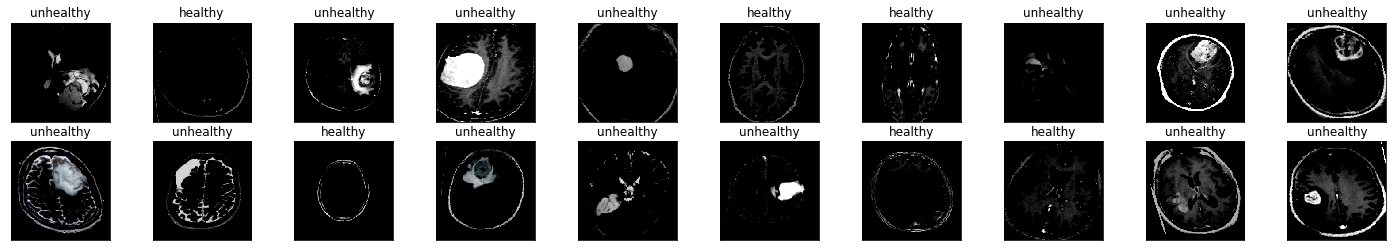

In [10]:
dataiter = iter(training_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title(classes[labels[idx].item()]) #her image için title

In [11]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:28<00:00, 19.2MB/s]


In [12]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in model.features.parameters():
  param.requires_grad = False # Conv layerların değişmesini engelledik. Sadece FC layerlar değişiyor.

In [14]:
# Netin sonunda classifier 1000 outputa sahip. Bize 2 output gerekiyor.

import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [16]:
epochs = 5
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_loader:
    #inputs = inputs.to(device)
    #labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels) # output ve labellar karşılaştırılıyor.
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # gelen outputlardan max değerli olanı alıyoruz.
    # ilk değer max score, ikinci değer max score'un index değerini döndürüyor.
    _, preds = torch.max(outputs, 1) 
    running_loss += loss.item()
    # single batch of images'da doğru prediction sayısını veriyor.
    running_corrects += torch.sum(preds == labels.data) 
        
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        #val_inputs = val_inputs.to(device)
        #val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1) 
        val_running_loss += val_loss.item()
        # single batch of images'da doğru prediction sayısını veriyor.
        val_running_corrects += torch.sum(val_preds == val_labels.data) 
    
    
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/len(training_loader.dataset)
    running_loss_history.append(epoch_loss) #epoch_loss, listeye eklendi.
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch', (e+1))
    print('Training Loss: {:.4f}, acc {:.4f}' .format(epoch_loss, epoch_acc.item()))
    print('Validation Loss: {:.4f}, acc {:.4f}' .format(val_epoch_loss, val_epoch_acc.item()))
    

epoch 1
Training Loss: 0.0329, acc 0.6403
Validation Loss: 0.0225, acc 0.8182
epoch 2
Training Loss: 0.0203, acc 0.8142
Validation Loss: 0.0176, acc 0.8656
epoch 3
Training Loss: 0.0160, acc 0.8775
Validation Loss: 0.0136, acc 0.8893
epoch 4
Training Loss: 0.0160, acc 0.8656
Validation Loss: 0.0118, acc 0.9091
epoch 5
Training Loss: 0.0137, acc 0.9051
Validation Loss: 0.0105, acc 0.9249


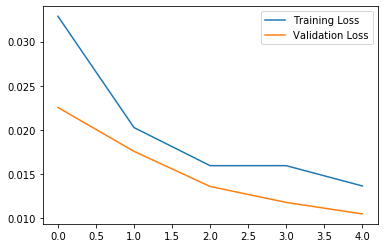

In [17]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

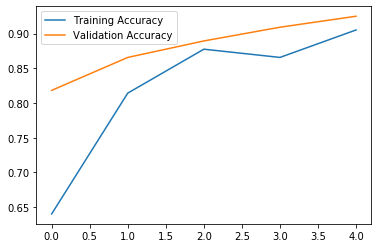

In [18]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()

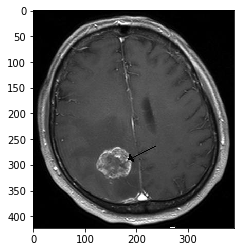

In [21]:
import requests
import PIL.ImageOps
from PIL import Image
url1 = 'https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly91cGxvYWQud2lraW1lZGlhLm9yZy93aWtpcGVkaWEvY29tbW9ucy81LzVmL0hpcm5tZXRhc3Rhc2VfTVJULVQxX0tNLmpwZw'
response = requests.get(url1, stream = True)
img1 = Image.open(response.raw)
plt.imshow(img1)

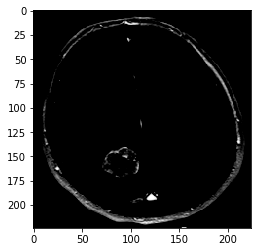

In [22]:
img1 = transform(img1)
plt.imshow(im_convert(img1))

In [23]:
img1 = img1.unsqueeze(0)
output = model(img1)
_, pred = torch.max(output, 1) 
print(classes[pred.item()])

unhealthy


unhealthy


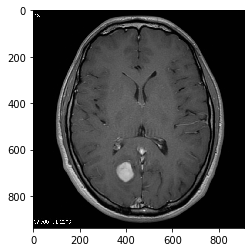

In [24]:
url2 = 'https://prod-images.static.radiopaedia.org/images/5651/b510dc0d5cd3906018c4dd49b98643.jpg'
response = requests.get(url2, stream = True)
img2 = Image.open(response.raw)
plt.imshow(img2)
img2 = transform(img2)
img2 = img2.unsqueeze(0)
output = model(img2)
_, pred = torch.max(output, 1) 
print(classes[pred.item()])

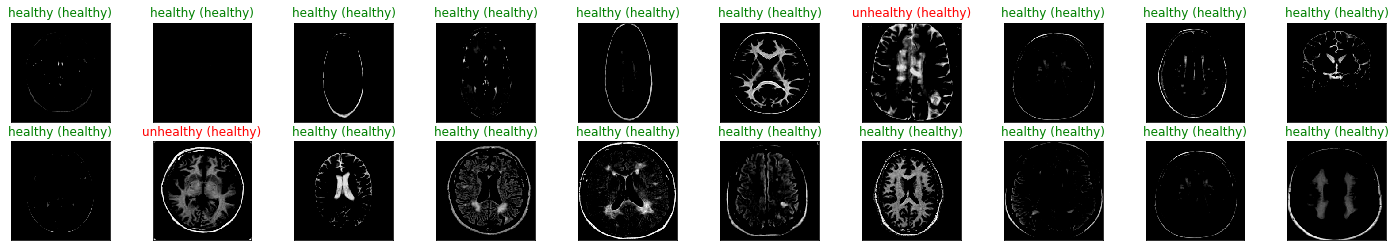

In [25]:
dataiter = iter(validation_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
images = images#.to(device)
labels = labels#.to(device)
output = model(images)
_, preds = torch.max(output, 1) 

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red")) #her image için title

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [33]:
!ls /content/gdrive/

'My Drive'


In [0]:
vgg_model = ('vgg_model.pt')
path = "/content/gdrive/My Drive/{vgg_model}" 
torch.save(model.state_dict(), path)